<a href="https://colab.research.google.com/github/WillKWL/Project-NBASeason/blob/master/1_load_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Does performance in pre-all star season predict playoff ranking? 
- supervised offline multi-class classification task
- performance measure: confusion matrix
- data source: https://www.nba.com/stats/teams/traditional/?sort=W&dir=-1&Season=2021-22&SeasonType=Regular%20Season 
- by predicting the probability of winning the championship based on mid-season (defined as regular season pre all-star game) performance of the NBA teams performance in the regular season before the All-Star game, 
  - As fans, we can tell whether our favorite team has a high chance to win this year during the middle of the season
  - As coaching staff and team manager, we can tell if we need to make a change in our roster to increase our chances

In [ ]:
!pip install nba_api

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 4.1 MB/s 
  Created wheel for nba-api: filename=nba_api-1.1.11-py3-none-any.whl size=251504 sha256=c59be169d82b469d6e7d20c70e5f94372260e514f170141e9851897b48efa401
  Stored in directory: /root/.cache/pip/wheels/e3/f4/46/996128675381abc175e306642bae575d372dcf7efc4683e551
Successfully built nba-api


In [ ]:
import pandas as pd
from nba_api.stats.endpoints import leaguedashteamstats, leaguedashplayerstats
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
import os
from tqdm import tqdm
import numpy as np
from zlib import crc32
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [20, 5]
import re

In [ ]:
# save to google drive
os.chdir('/content/drive/MyDrive/Colab Notebooks')

# Gather data with [nba api](https://github.com/swar/nba_api)
- stats adjusted per 100 posessions, instead of per game, to account for the different pace each team plays at
- [glossary](https://www.nba.com/stats/help/glossary/) for column names  
- extra data: [advanced team stats](https://www.nba.com/stats/teams/advanced/?sort=W&dir=-1) 



In [ ]:
per_mode = 'Per100Possessions'

def get_team_table(measure_type, season, season_type, season_segment=""):
  # documentation: https://github.com/swar/nba_api/blob/master/docs/nba_api/stats/endpoints/leaguedashteamstats.md
  return leaguedashteamstats.LeagueDashTeamStats(
      per_mode_detailed=per_mode, 
      measure_type_detailed_defense=measure_type,
      season=season, 
      season_type_all_star=season_type,
      season_segment_nullable=season_segment).get_data_frames()[0]

def get_player_table(measure_type, season, season_type, season_segment=""):
  # documentation: https://github.com/swar/nba_api/blob/master/docs/nba_api/stats/endpoints/leaguedashplayerstats.md
  return leaguedashplayerstats.LeagueDashPlayerStats(
      per_mode_detailed=per_mode, 
      measure_type_detailed_defense=measure_type,
      season=season, 
      season_type_all_star=season_type,
      season_segment_nullable=season_segment).get_data_frames()[0]

In [ ]:
season = '2021-22'
player_df = get_player_table("Base", season, "Regular Season", "Pre All-Star")

In [ ]:
player_df

,PLAYER_ID,PLAYER_NAME,NICKNAME,TEAM_ID,TEAM_ABBREVIATION,AGE,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,NBA_FANTASY_PTS,DD2,TD3,WNBA_FANTASY_PTS,GP_RANK,W_RANK,L_RANK,W_PCT_RANK,MIN_RANK,FGM_RANK,FGA_RANK,FG_PCT_RANK,FG3M_RANK,FG3A_RANK,FG3_PCT_RANK,FTM_RANK,FTA_RANK,FT_PCT_RANK,OREB_RANK,DREB_RANK,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,NBA_FANTASY_PTS_RANK,DD2_RANK,TD3_RANK,WNBA_FANTASY_PTS_RANK,CFID,CFPARAMS
0,203932,Aaron Gordon,Aaron,1610612743,DEN,26.0,53,31,22,0.585,48.9,8.7,16.8,0.516,1.8,5.4,0.333,3.2,4.4,0.735,2.6,6.3,8.9,4.0,2.7,1.0,0.8,1.0,2.9,3.9,22.3,7.3,42.0,4,0,40.9,65,51,160,206,101,142,233,108,320,358,255,182,186,321,195,269,247,229,210,411,249,208,477,190,165,84,258,87,34,237,5,"203932,1610612743"
1,1630565,Aaron Henry,Aaron,1610612755,PHI,22.0,6,6,0,1.000,44.7,2.6,13.2,0.200,0.0,2.6,0.000,0.0,0.0,0.000,0.0,2.6,2.6,0.0,5.3,0.0,5.3,5.3,5.3,0.0,5.3,-52.6,18.9,0,0,18.4,492,434,568,1,546,539,404,552,487,462,487,520,526,520,538,557,565,545,28,522,5,4,143,541,555,577,567,221,34,569,5,"1630565,1610612755"
2,1628988,Aaron Holiday,Aaron,1610612756,PHX,25.0,44,21,23,0.477,48.8,7.6,15.8,0.480,1.9,5.1,0.370,1.9,2.4,0.800,0.7,4.4,5.1,6.0,3.0,1.7,0.6,0.7,4.4,3.1,19.0,-4.9,38.1,0,0,36.6,204,210,140,331,120,222,282,180,303,377,162,353,379,204,477,477,504,132,165,166,321,365,230,285,270,383,338,221,34,324,5,"1628988,1610612756"
3,1630174,Aaron Nesmith,Aaron,1610612738,BOS,22.0,41,24,17,0.585,47.9,5.8,15.5,0.378,2.3,9.6,0.236,1.7,2.1,0.842,1.3,6.3,7.6,1.4,2.6,1.3,0.4,0.2,5.6,2.4,15.7,1.7,29.5,0,0,30.4,246,154,259,203,265,388,295,453,245,123,430,389,417,135,337,271,315,519,240,319,397,497,121,387,384,211,505,221,34,480,5,"1630174,1610612738"
4,1630598,Aaron Wiggins,Aaron,1610612760,OKC,23.0,34,9,25,0.265,47.9,5.7,12.2,0.464,1.7,5.5,0.307,2.3,3.2,0.706,1.9,5.3,7.2,2.4,1.7,1.5,0.5,0.7,4.2,2.5,15.3,-5.5,31.9,0,0,30.6,311,400,115,503,255,401,448,211,336,347,340,312,301,357,265,354,341,418,406,233,366,366,267,380,400,401,470,221,34,476,5,"1630598,1610612760"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
587,1628380,Zach Collins,Zach,1610612759,SAS,24.0,5,3,2,0.600,46.2,6.8,15.3,0.444,1.7,4.0,0.429,1.1,2.3,0.500,4.5,10.2,14.7,6.2,4.5,2.3,1.1,1.7,6.2,1.7,16.4,-1.7,49.0,0,0,45.8,502,477,505,182,508,294,302,279,337,420,44,454,398,479,89,70,75,127,50,80,173,68,84,472,357,311,129,221,34,133,5,"1628380,1610612759"
588,203897,Zach LaVine,Zach,1610612741,CHI,27.0,47,31,16,0.660,48.0,12.1,25.2,0.482,4.0,10.0,0.399,5.9,6.8,0.869,0.4,6.3,6.7,6.2,3.8,0.9,0.5,1.2,2.4,5.2,34.1,3.0,51.9,0,0,53.8,160,51,293,112,248,25,35,174,62,107,93,42,74,82,532,266,364,129,94,470,354,163,523,103,20,176,89,221,34,46,5,"203897,1610612741"
589,1630192,Zeke Nnaji,Zeke,1610612743,DEN,21.0,39,23,16,0.590,48.6,7.1,13.1,0.540,2.8,5.7,0.487,2.8,4.6,0.613,4.1,6.6,10.7,1.1,1.6,0.9,1.0,1.3,5.7,3.7,19.8,-2.8,38.4,0,0,38.1,274,174,293,194,153,266,407,80,181,334,30,229,167,442,113,241,176,529,438,462,214,127,117,214,242,334,330,221,34,297,5,"1630192,1610612743"
590,1630533,Ziaire Williams,Ziaire,1610612763,MEM,20.0,40,26,14,0.650,47.1,6.3,14.3,0.441,2.3,8.1,0.284,1.0,1.4,0.760,0.6,3.3,3.9,1.9,1.3,1.2,0.4,0.6,4.3,1.6,15.9,1.8,26.9,0,0,27.2,263,124,330,124,412,342,342,289,242,192,382,469,480,259,494,545,551,477,484,354,414,401,249,484,372,208,528,221,34,519,5,"1630533,1610612763"


In [ ]:
season = '2021-22'
player_df = get_player_table("Base", season, "Regular Season", "Pre All-Star")
list_of_measures = ["Advanced", "Misc", "Four Factors", "Scoring", "Opponent", "Defense"]
for measure in list_of_measures:
  try:
    result_df = get_player_table(measure, season, "Regular Season", "Pre All-Star")
    print(f"{measure} success")
    player_df = player_df.merge(
      result_df, 
      on = "PLAYER_ID", how = "inner", suffixes = ("", "_y"))
  except: 
    print(f"error at {measure}")

Advanced success
Misc success
error at Four Factors
Scoring success
error at Opponent
Defense success


In [ ]:
player_df.merge()

,PLAYER_ID,PLAYER_NAME,NICKNAME,TEAM_ID,TEAM_ABBREVIATION,AGE,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,NBA_FANTASY_PTS,DD2,TD3,WNBA_FANTASY_PTS,GP_RANK,W_RANK,L_RANK,W_PCT_RANK,MIN_RANK,FGM_RANK,FGA_RANK,FG_PCT_RANK,FG3M_RANK,FG3A_RANK,FG3_PCT_RANK,FTM_RANK,FTA_RANK,FT_PCT_RANK,OREB_RANK,DREB_RANK,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,NBA_FANTASY_PTS_RANK,DD2_RANK,TD3_RANK,WNBA_FANTASY_PTS_RANK,CFID,CFPARAMS,PLAYER_NAME_y,NICKNAME_y,TEAM_ID_y,TEAM_ABBREVIATION_y,AGE_y,GP_y,W_y,L_y,W_PCT_y,MIN_y,E_OFF_RATING,OFF_RATING,sp_work_OFF_RATING,E_DEF_RATING,DEF_RATING,sp_work_DEF_RATING,E_NET_RATING,NET_RATING,sp_work_NET_RATING,AST_PCT,AST_TO,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,TM_TOV_PCT,E_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,sp_work_PACE,PIE,POSS,FGM_y,FGA_y,FGM_PG,FGA_PG,FG_PCT_y,GP_RANK_y,W_RANK_y,L_RANK_y,W_PCT_RANK_y,MIN_RANK_y,E_OFF_RATING_RANK,OFF_RATING_RANK,sp_work_OFF_RATING_RANK,E_DEF_RATING_RANK,DEF_RATING_RANK,sp_work_DEF_RATING_RANK,E_NET_RATING_RANK,NET_RATING_RANK,sp_work_NET_RATING_RANK,AST_PCT_RANK,AST_TO_RANK,AST_RATIO_RANK,OREB_PCT_RANK,DREB_PCT_RANK,REB_PCT_RANK,TM_TOV_PCT_RANK,E_TOV_PCT_RANK,EFG_PCT_RANK,TS_PCT_RANK,USG_PCT_RANK,E_USG_PCT_RANK,E_PACE_RANK,PACE_RANK,sp_work_PACE_RANK,PIE_RANK,FGM_RANK_y,FGA_RANK_y,FGM_PG_RANK,FGA_PG_RANK,FG_PCT_RANK_y,CFID_y,CFPARAMS_y,PLAYER_NAME_y,NICKNAME_y,TEAM_ID_y,TEAM_ABBREVIATION_y,AGE_y,GP_y,W_y,L_y,W_PCT_y,MIN_y,PTS_OFF_TOV,PTS_2ND_CHANCE,PTS_FB,PTS_PAINT,OPP_PTS_OFF_TOV,OPP_PTS_2ND_CHANCE,OPP_PTS_FB,OPP_PTS_PAINT,BLK_y,BLKA_y,PF_y,PFD_y,NBA_FANTASY_PTS_y,GP_RANK_y,W_RANK_y,L_RANK_y,W_PCT_RANK_y,MIN_RANK_y,PTS_OFF_TOV_RANK,PTS_2ND_CHANCE_RANK,PTS_FB_RANK,PTS_PAINT_RANK,OPP_PTS_OFF_TOV_RANK,OPP_PTS_2ND_CHANCE_RANK,OPP_PTS_FB_RANK,OPP_PTS_PAINT_RANK,BLK_RANK_y,BLKA_RANK_y,PF_RANK_y,PFD_RANK_y,NBA_FANTASY_PTS_RANK_y,CFID_y,CFPARAMS_y,PLAYER_NAME_y,NICKNAME_y,TEAM_ID_y,TEAM_ABBREVIATION_y,AGE_y,GP_y,W_y,L_y,W_PCT_y,MIN_y,PCT_FGA_2PT,PCT_FGA_3PT,PCT_PTS_2PT,PCT_PTS_2PT_MR,PCT_PTS_3PT,PCT_PTS_FB,PCT_PTS_FT,PCT_PTS_OFF_TOV,PCT_PTS_PAINT,PCT_AST_2PM,PCT_UAST_2PM,PCT_AST_3PM,PCT_UAST_3PM,PCT_AST_FGM,PCT_UAST_FGM,FGM_y,FGA_y,FG_PCT_y,GP_RANK_y,W_RANK_y,L_RANK_y,W_PCT_RANK_y,MIN_RANK_y,PCT_FGA_2PT_RANK,PCT_FGA_3PT_RANK,PCT_PTS_2PT_RANK,PCT_PTS_2PT_MR_RANK,PCT_PTS_3PT_RANK,PCT_PTS_FB_RANK,PCT_PTS_FT_RANK,PCT_PTS_OFF_TOV_RANK,PCT_PTS_PAINT_RANK,PCT_AST_2PM_RANK,PCT_UAST_2PM_RANK,PCT_AST_3PM_RANK,PCT_UAST_3PM_RANK,PCT_AST_FGM_RANK,PCT_UAST_FGM_RANK,FGM_RANK_y,FGA_RANK_y,FG_PCT_RANK_y,CFID_y,CFPARAMS_y,PLAYER_NAME_y,NICKNAME_y,TEAM_ID_y,TEAM_ABBREVIATION_y,AGE_y,GP_y,W_y,L_y,W_PCT_y,MIN_y,DEF_RATING_y,DREB_y,DREB_PCT_y,PCT_DREB,STL_y,PCT_STL,BLK_y,PCT_BLK,OPP_PTS_OFF_TOV_y,OPP_PTS_2ND_CHANCE_y,OPP_PTS_FB_y,OPP_PTS_PAINT_y,DEF_WS,GP_RANK_y,W_RANK_y,L_RANK_y,W_PCT_RANK_y,MIN_RANK_y,DEF_RATING_RANK_y,DREB_RANK_y,DREB_PCT_RANK_y,PCT_DREB_RANK,STL_RANK_y,PCT_STL_RANK,BLK_RANK_y,PCT_BLK_RANK,OPP_PTS_OFF_TOV_RANK_y,OPP_PTS_2ND_CHANCE_RANK_y,OPP_PTS_FB_RANK_y,OPP_PTS_PAINT_RANK_y,DEF_WS_RANK,CFID_y,CFPARAMS_y
0,203932,Aaron Gordon,Aaron,1610612743,DEN,26.0,53,31,22,0.585,48.9,8.7,16.8,0.516,1.8,5.4,0.333,3.2,4.4,0.735,2.6,6.3,8.9,4.0,2.7,1.0,0.8,1.0,2.9,3.9,22.3,7.3,42.0,4,0,40.9,65,51,160,206,101,142,233,108,320,358,255,182,186,321,195,269,247,229,210,411,249,208,477,190,165,84,258,87,34,237,5,"203932,1610612743",Aaron Gordon,Aaron,1610612743,DEN,26.0,53,31,22,0.585,31.8,114.2,116.5,116.5,108.8,109.4,109.4,5.4,7.0,7.0,0.114,1.48,15.9,0.057,0.124,0.093,10.8,10.7,0.570,0.598,0.191,0.193,99.38,98.10,81.75,98.10,0.097,3444,298,577,5.6,10.9,0.516,65,51,412,206,77,47,26,26,310,328,328,117,88,88,273,306,277,171,276,226,370,373,122,118,207,223,400,497,497,205,65,87,87,111,108,5,"203932,1610612743",Aaron Gordon,Aaron,1610612743,DEN,26.0,53,31,22,0.585,48.9,3.6,2.5,3.1,12.0,16.7,11.2,11.5,51.3,0.8,1.0,2.9,3.9,42.0,65,51,412,206,101,148,

In [ ]:
season = '2021-22'
season_df = get_team_table("Base", season, "Regular Season", "Pre All-Star")
list_of_measures = ["Advanced", "Misc", "Four Factors", "Scoring", "Opponent", "Defense"]
for measure in list_of_measures:
  try:
    print(measure)
    print(get_team_table(measure, season, "Regular Season", "Pre All-Star").columns.values)
  except:
    print(f"error at {measure}")

Advanced
['TEAM_ID' 'TEAM_NAME' 'GP' 'W' 'L' 'W_PCT' 'MIN' 'E_OFF_RATING'
 'OFF_RATING' 'E_DEF_RATING' 'DEF_RATING' 'E_NET_RATING' 'NET_RATING'
 'AST_PCT' 'AST_TO' 'AST_RATIO' 'OREB_PCT' 'DREB_PCT' 'REB_PCT'
 'TM_TOV_PCT' 'EFG_PCT' 'TS_PCT' 'E_PACE' 'PACE' 'PACE_PER40' 'POSS' 'PIE'
 'GP_RANK' 'W_RANK' 'L_RANK' 'W_PCT_RANK' 'MIN_RANK' 'OFF_RATING_RANK'
 'DEF_RATING_RANK' 'NET_RATING_RANK' 'AST_PCT_RANK' 'AST_TO_RANK'
 'AST_RATIO_RANK' 'OREB_PCT_RANK' 'DREB_PCT_RANK' 'REB_PCT_RANK'
 'TM_TOV_PCT_RANK' 'EFG_PCT_RANK' 'TS_PCT_RANK' 'PACE_RANK' 'PIE_RANK'
 'CFID' 'CFPARAMS']
Misc
['TEAM_ID' 'TEAM_NAME' 'GP' 'W' 'L' 'W_PCT' 'MIN' 'PTS_OFF_TOV'
 'PTS_2ND_CHANCE' 'PTS_FB' 'PTS_PAINT' 'OPP_PTS_OFF_TOV'
 'OPP_PTS_2ND_CHANCE' 'OPP_PTS_FB' 'OPP_PTS_PAINT' 'GP_RANK' 'W_RANK'
 'L_RANK' 'W_PCT_RANK' 'MIN_RANK' 'PTS_OFF_TOV_RANK' 'PTS_2ND_CHANCE_RANK'
 'PTS_FB_RANK' 'PTS_PAINT_RANK' 'OPP_PTS_OFF_TOV_RANK'
 'OPP_PTS_2ND_CHANCE_RANK' 'OPP_PTS_FB_RANK' 'OPP_PTS_PAINT_RANK' 'CFID'
 'CFPARAMS']
Four Factors

In [ ]:
def season_vs_playoff(start_year, end_year):
  output = None
  season_list = [str(i) + '-' + str(i+1)[2:] for i in range(start_year, end_year)]
  with tqdm(total=len(season_list)) as pbar:
    for season in season_list:
      season_df = get_team_table("Base", season, "Regular Season", "Pre All-Star")
      list_of_measures = ["Advanced", "Misc", "Four Factors", "Scoring", "Opponent", "Defense"]
      for measure in list_of_measures:
        result_df = get_team_table(measure, season, "Regular Season", "Pre All-Star")
        print(f"{measure}: {result_df.columns.values}")
        season_df = season_df.merge(
            result_df, 
            on = "TEAM_ID", how = "inner", suffixes = ("", "_y"))

      playoff_df_base = get_team_table("Base", season, "Playoffs")
      playoff_df_opponent = get_team_table("Opponent", season, "Playoffs")
      playoff_df = playoff_df_base.merge(playoff_df_opponent, on = "TEAM_ID", how = "inner", suffixes = ("", "_y"))
      
      # # win 4 games = win 1 round
      # # ranking = 0 for teams which didn't enter playoffs
      # # ranking = 5 for champion which won 4 rounds, 16 games
      # if playoff_df['W'].max() == 16:
      #   # to win a championship, you need to win 4 rounds of best-of-7 (4,4,4,4)
      #   playoff_df['PLAYOFF_RANKING'] = playoff_df['W'].apply(lambda x: int(x/4) + 1)
      # elif playoff_df['W'].max() == 15:
      #   # 2001-02 season is the last season with best-of-5 in 1st round (3,4,4,4) so lets add 1 back to make ranking easier
      #   playoff_df['PLAYOFF_RANKING'] = playoff_df['W'].apply(lambda x: int((x+1)/4) + 1)

      # winning championship = 1, else = 0
      playoff_df = playoff_df.loc[playoff_df['W'] == playoff_df['W'].max()]
      playoff_df[['PLAYOFF_RANKING']] = 1

      playoff_df = playoff_df[['TEAM_ID', 'PLAYOFF_RANKING']] 

      season_vs_playoff = pd.merge(season_df, playoff_df, on='TEAM_ID', how = 'outer')
      season_vs_playoff.fillna(0, inplace=True) # teams which are not in playoff will have 0 as PLAYOFF_RANKING
      season_vs_playoff['PLAYOFF_RANKING'] = season_vs_playoff['PLAYOFF_RANKING'].astype(int)
      season_vs_playoff['SEASON'] = season
      output = pd.concat([output,season_vs_playoff.sort_values(by='PLAYOFF_RANKING', ascending = False).reset_index(drop=True)], axis = 0)

      pbar.update(1)
  
  return output

In [ ]:
df = season_vs_playoff(start_year = 1996, end_year = 2022)
df

100%|██████████| 26/26 [02:50<00:00,  6.56s/it]


,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,GP_RANK,W_RANK,L_RANK,W_PCT_RANK,MIN_RANK,FGM_RANK,FGA_RANK,FG_PCT_RANK,FG3M_RANK,FG3A_RANK,FG3_PCT_RANK,FTM_RANK,FTA_RANK,FT_PCT_RANK,OREB_RANK,DREB_RANK,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,CFID,CFPARAMS,TEAM_NAME_y,GP_y,W_y,L_y,W_PCT_y,MIN_y,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TO,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE,GP_RANK_y,W_RANK_y,L_RANK_y,W_PCT_RANK_y,MIN_RANK_y,OFF_RATING_RANK,DEF_RATING_RANK,NET_RATING_RANK,AST_PCT_RANK,AST_TO_RANK,AST_RATIO_RANK,OREB_PCT_RANK,DREB_PCT_RANK,REB_PCT_RANK,TM_TOV_PCT_RANK,EFG_PCT_RANK,TS_PCT_RANK,PACE_RANK,PIE_RANK,CFID_y,CFPARAMS_y,TEAM_NAME_y,GP_y,W_y,L_y,W_PCT_y,MIN_y,PTS_OFF_TOV,PTS_2ND_CHANCE,PTS_FB,PTS_PAINT,OPP_PTS_OFF_TOV,OPP_PTS_2ND_CHANCE,OPP_PTS_FB,OPP_PTS_PAINT,GP_RANK_y,W_RANK_y,L_RANK_y,W_PCT_RANK_y,MIN_RANK_y,PTS_OFF_TOV_RANK,PTS_2ND_CHANCE_RANK,PTS_FB_RANK,PTS_PAINT_RANK,OPP_PTS_OFF_TOV_RANK,OPP_PTS_2ND_CHANCE_RANK,OPP_PTS_FB_RANK,OPP_PTS_PAINT_RANK,CFID_y,CFPARAMS_y,TEAM_NAME_y,GP_y,W_y,L_y,W_PCT_y,MIN_y,EFG_PCT_y,FTA_RATE,TM_TOV_PCT_y,OREB_PCT_y,OPP_EFG_PCT,OPP_FTA_RATE,OPP_TOV_PCT,OPP_OREB_PCT,GP_RANK_y,W_RANK_y,L_RANK_y,W_PCT_RANK_y,MIN_RANK_y,EFG_PCT_RANK_y,FTA_RATE_RANK,TM_TOV_PCT_RANK_y,OREB_PCT_RANK_y,OPP_EFG_PCT_RANK,OPP_FTA_RATE_RANK,OPP_TOV_PCT_RANK,OPP_OREB_PCT_RANK,CFID_y,CFPARAMS_y,TEAM_NAME_y,GP_y,W_y,L_y,W_PCT_y,MIN_y,PCT_FGA_2PT,PCT_FGA_3PT,PCT_PTS_2PT,PCT_PTS_2PT_MR,PCT_PTS_3PT,PCT_PTS_FB,PCT_PTS_FT,PCT_PTS_OFF_TOV,PCT_PTS_PAINT,PCT_AST_2PM,PCT_UAST_2PM,PCT_AST_3PM,PCT_UAST_3PM,PCT_AST_FGM,PCT_UAST_FGM,GP_RANK_y,W_RANK_y,L_RANK_y,W_PCT_RANK_y,MIN_RANK_y,PCT_FGA_2PT_RANK,PCT_FGA_3PT_RANK,PCT_PTS_2PT_RANK,PCT_PTS_2PT_MR_RANK,PCT_PTS_3PT_RANK,PCT_PTS_FB_RANK,PCT_PTS_FT_RANK,PCT_PTS_OFF_TOV_RANK,PCT_PTS_PAINT_RANK,PCT_AST_2PM_RANK,PCT_UAST_2PM_RANK,PCT_AST_3PM_RANK,PCT_UAST_3PM_RANK,PCT_AST_FGM_RANK,PCT_UAST_FGM_RANK,CFID_y,CFPARAMS_y,TEAM_NAME_y,GP_y,W_y,L_y,W_PCT_y,MIN_y,OPP_FGM,OPP_FGA,OPP_FG_PCT,OPP_FG3M,OPP_FG3A,OPP_FG3_PCT,OPP_FTM,OPP_FTA,OPP_FT_PCT,OPP_OREB,OPP_DREB,OPP_REB,OPP_AST,OPP_TOV,OPP_STL,OPP_BLK,OPP_BLKA,OPP_PF,OPP_PFD,OPP_PTS,PLUS_MINUS_y,GP_RANK_y,W_RANK_y,L_RANK_y,W_PCT_RANK_y,MIN_RANK_y,OPP_FGM_RANK,OPP_FGA_RANK,OPP_FG_PCT_RANK,OPP_FG3M_RANK,OPP_FG3A_RANK,OPP_FG3_PCT_RANK,OPP_FTM_RANK,OPP_FTA_RANK,OPP_FT_PCT_RANK,OPP_OREB_RANK,OPP_DREB_RANK,OPP_REB_RANK,OPP_AST_RANK,OPP_TOV_RANK,OPP_STL_RANK,OPP_BLK_RANK,OPP_BLKA_RANK,OPP_PF_RANK,OPP_PFD_RANK,OPP_PTS_RANK,PLUS_MINUS_RANK_y,CFID_y,CFPARAMS_y,TEAM_NAME_y,GP_y,W_y,L_y,W_PCT_y,MIN_y,DEF_RATING_y,DREB_y,DREB_PCT_y,STL_y,BLK_y,OPP_PTS_OFF_TOV_y,OPP_PTS_2ND_CHANCE_y,OPP_PTS_FB_y,OPP_PTS_PAINT_y,GP_RANK_y,W_RANK_y,L_RANK_y,W_PCT_RANK_y,MIN_RANK_y,DEF_RATING_RANK_y,DREB_RANK_y,DREB_PCT_RANK_y,STL_RANK_y,BLK_RANK_y,OPP_PTS_OFF_TOV_RANK_y,OPP_PTS_2ND_CHANCE_RANK_y,OPP_PTS_FB_RANK_y,OPP_PTS_PAINT_RANK_y,CFID_y,CFPARAMS_y,PLAYOFF_RANKING,SEASON
0,1610612741,Chicago Bulls,48,42,6,0.875,52.4,43.4,92.0,0.471,6.8,18.9,0.361,18.0,24.3,0.743,16.0,32.3,48.2,27.7,14.3,9.5,4.1,3.8,21.2,0.1,111.6,12.8,3,1,1,1,13,1,1,2,12,10,12,26,27,11,2,8,2,2,1,7,27,1,1,21,1,1,10,Chicago Bulls,Chicago Bulls,48,42,6,0.875,2309.0,110.4,111.6,97.3,98.7,13.1,12.9,0.640,1.94,19.0,0.362,0.671,0.518,0.143,0.508,0.543,92.7,91.56,76.30,4403,0.592,3,1,1,1,12,1,3,1,7,1,2,4,10,3,1,4,7,16,1,10,Chicago Bulls,Chicago Bulls,48,42,6,0.875,52.4,21.4,17.9,13.9,39.1,14.9,15.7,11.1,41.7,3,1,1,1,12,5,1,13,24,1,18,6,11,10,Chicago Bulls,Chicago Bulls,48,42,6,0.875,2309.0,0.508,0.264,0.143,0.362,0.467,0.259,0.178,0.329,3,1,1,1,12,4,28,1,4,4,4,11,10,10,Chicago Bulls,Chicago Bulls,48,42,6,0.875,48.1,0.795,0.205,0.655,0.305,0.183,0.125,0.162,0.192,0.350,0.611,0.389,0.793,0.207,0.640,0.360,3,1,1,1,29,14,16,7,1,16,16,28,8,29,6,24,18,12,7,23,10,Chicago Bu

In [ ]:
df.to_csv('nba_pre_all_star_vs_playoff_comprehensive.csv', index = False)
# download local copy
from google.colab import files
files.download("nba_pre_all_star_vs_playoff_comprehensive.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df = pd.read_csv('https://github.com/WillKWL/PublicData/raw/main/raw/nba_pre_all_star_vs_playoff_comprehensive.csv')
df

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,GP_RANK,W_RANK,L_RANK,W_PCT_RANK,MIN_RANK,FGM_RANK,FGA_RANK,FG_PCT_RANK,FG3M_RANK,FG3A_RANK,FG3_PCT_RANK,FTM_RANK,FTA_RANK,FT_PCT_RANK,OREB_RANK,DREB_RANK,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,CFID,CFPARAMS,TEAM_NAME_y,GP_y,W_y,L_y,W_PCT_y,MIN_y,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TO,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE,GP_RANK_y,W_RANK_y,L_RANK_y,W_PCT_RANK_y,MIN_RANK_y,OFF_RATING_RANK,DEF_RATING_RANK,NET_RATING_RANK,AST_PCT_RANK,AST_TO_RANK,AST_RATIO_RANK,OREB_PCT_RANK,DREB_PCT_RANK,REB_PCT_RANK,TM_TOV_PCT_RANK,EFG_PCT_RANK,TS_PCT_RANK,PACE_RANK,PIE_RANK,CFID_y,CFPARAMS_y,TEAM_NAME_y.1,GP_y.1,W_y.1,L_y.1,W_PCT_y.1,MIN_y.1,PTS_OFF_TOV,PTS_2ND_CHANCE,PTS_FB,PTS_PAINT,OPP_PTS_OFF_TOV,OPP_PTS_2ND_CHANCE,OPP_PTS_FB,OPP_PTS_PAINT,GP_RANK_y.1,W_RANK_y.1,L_RANK_y.1,W_PCT_RANK_y.1,MIN_RANK_y.1,PTS_OFF_TOV_RANK,PTS_2ND_CHANCE_RANK,PTS_FB_RANK,PTS_PAINT_RANK,OPP_PTS_OFF_TOV_RANK,OPP_PTS_2ND_CHANCE_RANK,OPP_PTS_FB_RANK,OPP_PTS_PAINT_RANK,CFID_y.1,CFPARAMS_y.1,TEAM_NAME_y.2,GP_y.2,W_y.2,L_y.2,W_PCT_y.2,MIN_y.2,EFG_PCT_y,FTA_RATE,TM_TOV_PCT_y,OREB_PCT_y,OPP_EFG_PCT,OPP_FTA_RATE,OPP_TOV_PCT,OPP_OREB_PCT,GP_RANK_y.2,W_RANK_y.2,L_RANK_y.2,W_PCT_RANK_y.2,MIN_RANK_y.2,EFG_PCT_RANK_y,FTA_RATE_RANK,TM_TOV_PCT_RANK_y,OREB_PCT_RANK_y,OPP_EFG_PCT_RANK,OPP_FTA_RATE_RANK,OPP_TOV_PCT_RANK,OPP_OREB_PCT_RANK,CFID_y.2,CFPARAMS_y.2,TEAM_NAME_y.3,GP_y.3,W_y.3,L_y.3,W_PCT_y.3,MIN_y.3,PCT_FGA_2PT,PCT_FGA_3PT,PCT_PTS_2PT,PCT_PTS_2PT_MR,PCT_PTS_3PT,PCT_PTS_FB,PCT_PTS_FT,PCT_PTS_OFF_TOV,PCT_PTS_PAINT,PCT_AST_2PM,PCT_UAST_2PM,PCT_AST_3PM,PCT_UAST_3PM,PCT_AST_FGM,PCT_UAST_FGM,GP_RANK_y.3,W_RANK_y.3,L_RANK_y.3,W_PCT_RANK_y.3,MIN_RANK_y.3,PCT_FGA_2PT_RANK,PCT_FGA_3PT_RANK,PCT_PTS_2PT_RANK,PCT_PTS_2PT_MR_RANK,PCT_PTS_3PT_RANK,PCT_PTS_FB_RANK,PCT_PTS_FT_RANK,PCT_PTS_OFF_TOV_RANK,PCT_PTS_PAINT_RANK,PCT_AST_2PM_RANK,PCT_UAST_2PM_RANK,PCT_AST_3PM_RANK,PCT_UAST_3PM_RANK,PCT_AST_FGM_RANK,PCT_UAST_FGM_RANK,CFID_y.3,CFPARAMS_y.3,TEAM_NAME_y.4,GP_y.4,W_y.4,L_y.4,W_PCT_y.4,MIN_y.4,OPP_FGM,OPP_FGA,OPP_FG_PCT,OPP_FG3M,OPP_FG3A,OPP_FG3_PCT,OPP_FTM,OPP_FTA,OPP_FT_PCT,OPP_OREB,OPP_DREB,OPP_REB,OPP_AST,OPP_TOV,OPP_STL,OPP_BLK,OPP_BLKA,OPP_PF,OPP_PFD,OPP_PTS,PLUS_MINUS_y,GP_RANK_y.4,W_RANK_y.4,L_RANK_y.4,W_PCT_RANK_y.4,MIN_RANK_y.4,OPP_FGM_RANK,OPP_FGA_RANK,OPP_FG_PCT_RANK,OPP_FG3M_RANK,OPP_FG3A_RANK,OPP_FG3_PCT_RANK,OPP_FTM_RANK,OPP_FTA_RANK,OPP_FT_PCT_RANK,OPP_OREB_RANK,OPP_DREB_RANK,OPP_REB_RANK,OPP_AST_RANK,OPP_TOV_RANK,OPP_STL_RANK,OPP_BLK_RANK,OPP_BLKA_RANK,OPP_PF_RANK,OPP_PFD_RANK,OPP_PTS_RANK,PLUS_MINUS_RANK_y,CFID_y.4,CFPARAMS_y.4,TEAM_NAME_y.5,GP_y.5,W_y.5,L_y.5,W_PCT_y.5,MIN_y.5,DEF_RATING_y,DREB_y,DREB_PCT_y,STL_y,BLK_y,OPP_PTS_OFF_TOV_y,OPP_PTS_2ND_CHANCE_y,OPP_PTS_FB_y,OPP_PTS_PAINT_y,GP_RANK_y.5,W_RANK_y.5,L_RANK_y.5,W_PCT_RANK_y.5,MIN_RANK_y.5,DEF_RATING_RANK_y,DREB_RANK_y,DREB_PCT_RANK_y,STL_RANK_y,BLK_RANK_y,OPP_PTS_OFF_TOV_RANK_y,OPP_PTS_2ND_CHANCE_RANK_y,OPP_PTS_FB_RANK_y,OPP_PTS_PAINT_RANK_y,CFID_y.5,CFPARAMS_y.5,PLAYOFF_RANKING,SEASON
0,1610612741,Chicago Bulls,48,42,6,0.875,52.4,43.4,92.0,0.471,6.8,18.9,0.361,18.0,24.3,0.743,16.0,32.3,48.2,27.7,14.3,9.5,4.1,3.8,21.2,0.1,111.6,12.8,3,1,1,1,13,1,1,2,12,10,12,26,27,11,2,8,2,2,1,7,27,1,1,21,1,1,10,Chicago Bulls,Chicago Bulls,48,42,6,0.875,2309.0,110.4,111.6,97.3,98.7,13.1,12.9,0.640,1.94,19.0,0.362,0.671,0.518,0.143,0.508,0.543,92.7,91.56,76.30,4403,0.592,3,1,1,1,12,1,3,1,7,1,2,4,10,3,1,4,7,16,1,10,Chicago Bulls,Chicago Bulls,48,42,6,0.875,52.4,21.4,17.9,13.9,39.1,14.9,15.7,11.1,41.7,3,1,1,1,12,5,1,13,24,1,18,6,11,10,Chicago Bulls,Chicago Bulls,48,42,6,0.875,2309.0,0.508,0.264,0.143,0.362,0.467,0.259,0.178,0.329,3,1,1,1,12,4,28,1,4,4,4,11,10,10,Chicago Bulls,Chicago Bulls,48,42,6,0.875,48.1,0.795,0.205,0.655,0.305,

In [ ]:
pd.DataFrame(df.dtypes).T

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,GP_RANK,W_RANK,L_RANK,W_PCT_RANK,MIN_RANK,FGM_RANK,FGA_RANK,FG_PCT_RANK,FG3M_RANK,FG3A_RANK,FG3_PCT_RANK,FTM_RANK,FTA_RANK,FT_PCT_RANK,OREB_RANK,DREB_RANK,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,CFID,CFPARAMS,TEAM_NAME_y,GP_y,W_y,L_y,W_PCT_y,MIN_y,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TO,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE,GP_RANK_y,W_RANK_y,L_RANK_y,W_PCT_RANK_y,MIN_RANK_y,OFF_RATING_RANK,DEF_RATING_RANK,NET_RATING_RANK,AST_PCT_RANK,AST_TO_RANK,AST_RATIO_RANK,OREB_PCT_RANK,DREB_PCT_RANK,REB_PCT_RANK,TM_TOV_PCT_RANK,EFG_PCT_RANK,TS_PCT_RANK,PACE_RANK,PIE_RANK,CFID_y,CFPARAMS_y,TEAM_NAME_y.1,GP_y.1,W_y.1,L_y.1,W_PCT_y.1,MIN_y.1,PTS_OFF_TOV,PTS_2ND_CHANCE,PTS_FB,PTS_PAINT,OPP_PTS_OFF_TOV,OPP_PTS_2ND_CHANCE,OPP_PTS_FB,OPP_PTS_PAINT,GP_RANK_y.1,W_RANK_y.1,L_RANK_y.1,W_PCT_RANK_y.1,MIN_RANK_y.1,PTS_OFF_TOV_RANK,PTS_2ND_CHANCE_RANK,PTS_FB_RANK,PTS_PAINT_RANK,OPP_PTS_OFF_TOV_RANK,OPP_PTS_2ND_CHANCE_RANK,OPP_PTS_FB_RANK,OPP_PTS_PAINT_RANK,CFID_y.1,CFPARAMS_y.1,TEAM_NAME_y.2,GP_y.2,W_y.2,L_y.2,W_PCT_y.2,MIN_y.2,EFG_PCT_y,FTA_RATE,TM_TOV_PCT_y,OREB_PCT_y,OPP_EFG_PCT,OPP_FTA_RATE,OPP_TOV_PCT,OPP_OREB_PCT,GP_RANK_y.2,W_RANK_y.2,L_RANK_y.2,W_PCT_RANK_y.2,MIN_RANK_y.2,EFG_PCT_RANK_y,FTA_RATE_RANK,TM_TOV_PCT_RANK_y,OREB_PCT_RANK_y,OPP_EFG_PCT_RANK,OPP_FTA_RATE_RANK,OPP_TOV_PCT_RANK,OPP_OREB_PCT_RANK,CFID_y.2,CFPARAMS_y.2,TEAM_NAME_y.3,GP_y.3,W_y.3,L_y.3,W_PCT_y.3,MIN_y.3,PCT_FGA_2PT,PCT_FGA_3PT,PCT_PTS_2PT,PCT_PTS_2PT_MR,PCT_PTS_3PT,PCT_PTS_FB,PCT_PTS_FT,PCT_PTS_OFF_TOV,PCT_PTS_PAINT,PCT_AST_2PM,PCT_UAST_2PM,PCT_AST_3PM,PCT_UAST_3PM,PCT_AST_FGM,PCT_UAST_FGM,GP_RANK_y.3,W_RANK_y.3,L_RANK_y.3,W_PCT_RANK_y.3,MIN_RANK_y.3,PCT_FGA_2PT_RANK,PCT_FGA_3PT_RANK,PCT_PTS_2PT_RANK,PCT_PTS_2PT_MR_RANK,PCT_PTS_3PT_RANK,PCT_PTS_FB_RANK,PCT_PTS_FT_RANK,PCT_PTS_OFF_TOV_RANK,PCT_PTS_PAINT_RANK,PCT_AST_2PM_RANK,PCT_UAST_2PM_RANK,PCT_AST_3PM_RANK,PCT_UAST_3PM_RANK,PCT_AST_FGM_RANK,PCT_UAST_FGM_RANK,CFID_y.3,CFPARAMS_y.3,TEAM_NAME_y.4,GP_y.4,W_y.4,L_y.4,W_PCT_y.4,MIN_y.4,OPP_FGM,OPP_FGA,OPP_FG_PCT,OPP_FG3M,OPP_FG3A,OPP_FG3_PCT,OPP_FTM,OPP_FTA,OPP_FT_PCT,OPP_OREB,OPP_DREB,OPP_REB,OPP_AST,OPP_TOV,OPP_STL,OPP_BLK,OPP_BLKA,OPP_PF,OPP_PFD,OPP_PTS,PLUS_MINUS_y,GP_RANK_y.4,W_RANK_y.4,L_RANK_y.4,W_PCT_RANK_y.4,MIN_RANK_y.4,OPP_FGM_RANK,OPP_FGA_RANK,OPP_FG_PCT_RANK,OPP_FG3M_RANK,OPP_FG3A_RANK,OPP_FG3_PCT_RANK,OPP_FTM_RANK,OPP_FTA_RANK,OPP_FT_PCT_RANK,OPP_OREB_RANK,OPP_DREB_RANK,OPP_REB_RANK,OPP_AST_RANK,OPP_TOV_RANK,OPP_STL_RANK,OPP_BLK_RANK,OPP_BLKA_RANK,OPP_PF_RANK,OPP_PFD_RANK,OPP_PTS_RANK,PLUS_MINUS_RANK_y,CFID_y.4,CFPARAMS_y.4,TEAM_NAME_y.5,GP_y.5,W_y.5,L_y.5,W_PCT_y.5,MIN_y.5,DEF_RATING_y,DREB_y,DREB_PCT_y,STL_y,BLK_y,OPP_PTS_OFF_TOV_y,OPP_PTS_2ND_CHANCE_y,OPP_PTS_FB_y,OPP_PTS_PAINT_y,GP_RANK_y.5,W_RANK_y.5,L_RANK_y.5,W_PCT_RANK_y.5,MIN_RANK_y.5,DEF_RATING_RANK_y,DREB_RANK_y,DREB_PCT_RANK_y,STL_RANK_y,BLK_RANK_y,OPP_PTS_OFF_TOV_RANK_y,OPP_PTS_2ND_CHANCE_RANK_y,OPP_PTS_FB_RANK_y,OPP_PTS_PAINT_RANK_y,CFID_y.5,CFPARAMS_y.5,PLAYOFF_RANKING,SEASON
0,int64,object,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,object,object,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,object,object,int64,int64,int64,floa

# Remove duplicate columns

In [ ]:
remaining_col = [x for x in df.columns if 
                 (re.search('_RANK$', x) is None) &   # remove columns ending in _RANK as we will clean our features later
                 (re.search('_y$', x) is None) &      # remove duplicate columns ending in _y
                 (re.search('_y.\w+$', x) is None) &  # remove duplicate columns ending in _y.1, _y.2, _y.3, etc.
                 (re.search('^E_\w+', x) is None)     # remove columns starting with E_ (unknown estimates provided by NBA)
                 ]
df = df[remaining_col]

In [ ]:
df

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,CFID,CFPARAMS,OFF_RATING,DEF_RATING,NET_RATING,AST_PCT,AST_TO,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,PACE,PACE_PER40,POSS,PIE,PTS_OFF_TOV,PTS_2ND_CHANCE,PTS_FB,PTS_PAINT,OPP_PTS_OFF_TOV,OPP_PTS_2ND_CHANCE,OPP_PTS_FB,OPP_PTS_PAINT,FTA_RATE,OPP_EFG_PCT,OPP_FTA_RATE,OPP_TOV_PCT,OPP_OREB_PCT,PCT_FGA_2PT,PCT_FGA_3PT,PCT_PTS_2PT,PCT_PTS_2PT_MR,PCT_PTS_3PT,PCT_PTS_FB,PCT_PTS_FT,PCT_PTS_OFF_TOV,PCT_PTS_PAINT,PCT_AST_2PM,PCT_UAST_2PM,PCT_AST_3PM,PCT_UAST_3PM,PCT_AST_FGM,PCT_UAST_FGM,OPP_FGM,OPP_FGA,OPP_FG_PCT,OPP_FG3M,OPP_FG3A,OPP_FG3_PCT,OPP_FTM,OPP_FTA,OPP_FT_PCT,OPP_OREB,OPP_DREB,OPP_REB,OPP_AST,OPP_TOV,OPP_STL,OPP_BLK,OPP_BLKA,OPP_PF,OPP_PFD,OPP_PTS,PLAYOFF_RANKING,SEASON
0,1610612741,Chicago Bulls,48,42,6,0.875,52.4,43.4,92.0,0.471,6.8,18.9,0.361,18.0,24.3,0.743,16.0,32.3,48.2,27.7,14.3,9.5,4.1,3.8,21.2,0.1,111.6,12.8,10,Chicago Bulls,111.6,98.7,12.9,0.640,1.94,19.0,0.362,0.671,0.518,0.143,0.508,0.543,91.56,76.30,4403,0.592,21.4,17.9,13.9,39.1,14.9,15.7,11.1,41.7,0.264,0.467,0.259,0.178,0.329,0.795,0.205,0.655,0.305,0.183,0.125,0.162,0.192,0.350,0.611,0.389,0.793,0.207,0.640,0.360,38.1,88.0,0.433,6.0,18.7,0.318,16.6,22.8,0.727,14.4,29.9,44.3,20.8,17.9,7.9,3.8,4.1,23.0,21.2,98.8,1,1996-97
1,1610612737,Atlanta Hawks,46,31,15,0.674,54.8,38.2,87.1,0.438,8.9,24.8,0.360,20.1,26.4,0.760,14.1,33.3,47.5,20.1,16.7,8.6,6.1,4.6,21.8,0.1,105.4,5.8,10,Atlanta Hawks,105.4,99.5,5.9,0.527,1.21,14.7,0.336,0.667,0.506,0.167,0.490,0.534,87.65,73.04,4066,0.533,18.3,15.4,8.5,37.8,18.4,16.5,12.9,41.6,0.303,0.466,0.236,0.168,0.333,0.716,0.284,0.555,0.196,0.254,0.081,0.190,0.174,0.359,0.473,0.527,0.702,0.298,0.527,0.473,38.7,90.4,0.428,6.8,19.9,0.342,15.4,21.3,0.722,14.8,31.4,46.2,23.3,16.8,8.0,4.6,6.1,24.2,21.8,99.6,0,1996-97
2,1610612750,Minnesota Timberwolves,48,23,25,0.479,52.1,38.0,85.1,0.447,4.7,13.8,0.343,22.0,29.2,0.756,13.5,29.9,43.4,23.3,16.8,8.4,7.7,5.9,24.3,0.2,102.9,-2.2,10,Minnesota Timberwolves,102.9,105.1,-2.2,0.613,1.39,16.7,0.333,0.641,0.487,0.168,0.475,0.525,92.17,76.81,4445,0.495,19.4,15.3,10.6,38.4,18.3,14.8,14.0,44.3,0.343,0.488,0.339,0.177,0.359,0.838,0.162,0.648,0.274,0.138,0.103,0.214,0.189,0.374,0.608,0.392,0.643,0.357,0.613,0.387,38.8,85.6,0.453,6.1,16.4,0.370,21.4,29.0,0.739,14.2,31.3,45.5,23.5,17.7,8.3,5.9,7.7,24.4,24.3,105.0,0,1996-97
3,1610612763,Vancouver Grizzlies,51,9,42,0.176,53.1,38.1,88.6,0.430,5.8,17.3,0.337,15.6,22.4,0.696,14.1,28.4,42.5,25.1,17.2,9.6,6.1,6.4,23.4,0.0,97.5,-12.1,10,Vancouver Grizzlies,97.5,109.3,-11.8,0.659,1.46,17.8,0.324,0.609,0.461,0.172,0.462,0.495,90.55,75.46,4630,0.425,18.4,15.4,13.6,41.6,19.4,17.5,16.2,49.9,0.252,0.509,0.302,0.179,0.391,0.804,0.196,0.661,0.234,0.179,0.139,0.160,0.189,0.427,0.627,0.373,0.833,0.167,0.659,0.341,41.7,88.4,0.472,6.6,18.1,0.363,19.7,26.7,0.736,16.7,33.8,50.5,26.7,17.9,9.6,6.4,6.1,21.2,23.4,109.6,0,1996-97
4,1610612762,Utah Jazz,47,33,14,0.702,53.0,40.6,83.0,0.490,4.4,12.2,0.362,22.7,29.9,0.759,11.8,32.3,44.1,28.2,17.0,9.7,5.1,5.2,26.6,0.3,108.4,7.1,10,Utah Jazz,108.4,100.9,7.4,0.695,1.66,19.9,0.311,0.687,0.508,0.170,0.516,0.563,90.74,75.62,4305,0.571,20.4,12.8,14.3,45.9,17.7,14.0,9.0,37.1,0.360,0.474,0.381,0.179,0.313,0.853,0.147,0.668,0.244,0.122,0.132,0.209,0.188,0.424,0.688,0.312,0.747,0.253,0.695,0.305,35.6,82.3,0.432,6.8,20.1,0.337,23.3,31.4,0.744,12.8,29.5,42.3,21.2,17.9,8.4,5.2,5.1,26.3,26.6,101.3,0,1996-97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
767,1610612739,Cleveland Cavaliers,58,35,23,0.603,49.5,40.8,87.6,0.466,12.1,34.3,0.353,16.2,21.5,0.755,10.6,35.6

In [ ]:
df.describe()

,TEAM_ID,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,CFID,OFF_RATING,DEF_RATING,NET_RATING,AST_PCT,AST_TO,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,PACE,PACE_PER40,POSS,PIE,PTS_OFF_TOV,PTS_2ND_CHANCE,PTS_FB,PTS_PAINT,OPP_PTS_OFF_TOV,OPP_PTS_2ND_CHANCE,OPP_PTS_FB,OPP_PTS_PAINT,FTA_RATE,OPP_EFG_PCT,OPP_FTA_RATE,OPP_TOV_PCT,OPP_OREB_PCT,PCT_FGA_2PT,PCT_FGA_3PT,PCT_PTS_2PT,PCT_PTS_2PT_MR,PCT_PTS_3PT,PCT_PTS_FB,PCT_PTS_FT,PCT_PTS_OFF_TOV,PCT_PTS_PAINT,PCT_AST_2PM,PCT_UAST_2PM,PCT_AST_3PM,PCT_UAST_3PM,PCT_AST_FGM,PCT_UAST_FGM,OPP_FGM,OPP_FGA,OPP_FG_PCT,OPP_FG3M,OPP_FG3A,OPP_FG3_PCT,OPP_FTM,OPP_FTA,OPP_FT_PCT,OPP_OREB,OPP_DREB,OPP_REB,OPP_AST,OPP_TOV,OPP_STL,OPP_BLK,OPP_BLKA,OPP_PF,OPP_PFD,OPP_PTS,PLAYOFF_RANKING
count,7.720000e+02,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.0,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.00000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000
mean,1.610613e+09,50.606218,25.303109,25.303109,0.499927,50.931347,39.070725,86.721762,0.450617,7.552591,21.299741,0.352225,19.233679,25.505699,0.755329,11.930829,32.950259,44.883031,23.044301,15.545078,8.098187,5.247409,5.247668,22.495337,14.376554,104.927850,0.006606,10.0,104.926813,104.922409,0.007642,0.589575,1.500078,16.735881,0.300760,0.698909,0.500008,0.155451,0.494097,0.535811,94.388303,78.657034,4817.791451,0.49989,17.381995,14.031218,13.379922,43.266839,17.378238,14.024482,13.398964,43.254793,0.294955,0.493992,0.295417,0.155453,0.301092,0.754907,0.245093,0.602417,0.190051,0.213899,0.127639,0.183692,0.165990,0.412380,0.527802,0.472199,0.846144,0.153858,0.589578,0.410426,39.058290,86.699611,0.450501,7.557642,21.312435,0.353225,19.249223,25.529404,0.754902,11.922927,32.947539,44.871114,23.037306,15.546244,8.094819,5.247668,5.247280,22.484456,22.495207,104.920855,0.033679
std,8.614750e+00,12.211405,10.248601,10.268956,0.161748,1.968573,1.697598,2.311684,0.017928,2.829515,7.546998,0.024174,2.451597,3.376242,0.034613,1.891570,1.870999,1.998381,2.046821,1.527708,1.065883,0.998342,0.853045,2.424332,10.171170,4.639576,4.990483,0.0,4.640343,4.436177,4.934053,0.042955,0.222294,1.321535,0.031993,0.027166,0.014442,0.015277,0.028033,0.025267,3.707082,3.088978,1177.865571,0.03663,1.810683,1.742539,2.860995,4.303229,1.738783,1.417762,1.964272,3.874680,0.044751,0.026698,0.045026,0.015774,0.027167,0.085182,0.085182,0.059164,0.065685,0.073466,0.027160,0.025057,0.019036,0.037223,0.054937,0.054936,0.053852,0.053853,0.042955,0.042951,1.833638,2.361206,0.017510,2.535047,6.832140,0.022353,2.395091,3.318580,0.021278,1.601007,1.797096,1.819988,1.792681,1.578010,0.880396,0.853045,0.998406,2.349825,2.424216,4.469277,0.180518
min,1.610613e+09,4.000000,0.000000,0.000000,0.000000,45.500000,33.500000,78.500000,0.373000,1.500000,5.100000,0.263000,10.600000,16.900000,0.560000,7.500000,26.200000,37.600000,15.400000,11.100000,5.700000,1.900000,3.100000,16.900000,0.000000,89.500000,-15.500000,10.0,89.500000,86.000000,-15.700000,0.442000,0.820000,11.800000,0.213000,0.602000,0.447000,0.111000,0.393000,0.434000,84.640000,70.540000,361.000000,0.39400,12.

# Remove outlier rows by GP

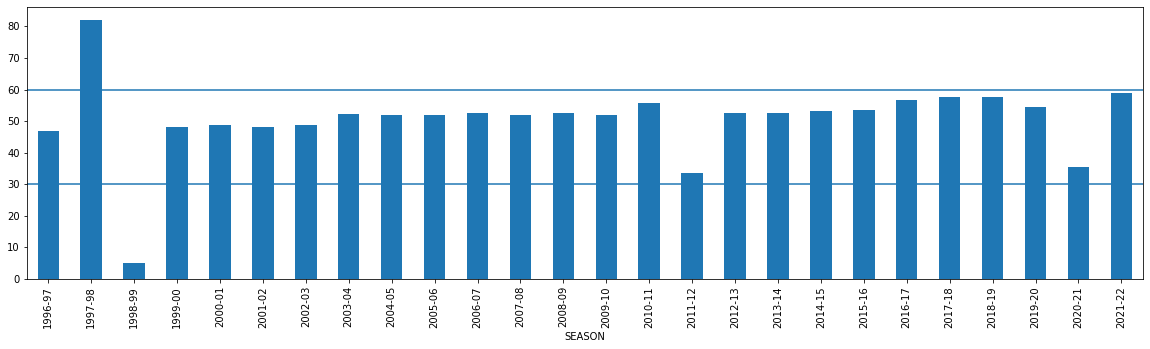

In [ ]:
# consider removing outlier in terms of games played 
# since those records are not representative samples of mid-season performance
# 1997-98: 82 games played = whole season but not mid-season, 
  # all-star game was held in Feb (Kobe's debut for youngest all-star player)
  # season lasted from Oct to Apr
# 1998-89: see 1998 NBA lockout
  # < 10 games played = too small of a sample size to gauge mid-season performance
# 2011-12: see 2011 NBA lockout
# 2020-21: see postponed season due to COVID-19
df.groupby('SEASON').GP.mean().plot(kind='bar')
plt.axhline(30)
plt.axhline(60)

In [ ]:
# cannot pass this in sklearn pipeline so let's do it on dataset level
# drop any season with games played <= 30 or >= 60 such that we have a large enough sample to gauge mid-season performance
df = df.loc[(df.GP >= 30) & (df.GP <= 60)]

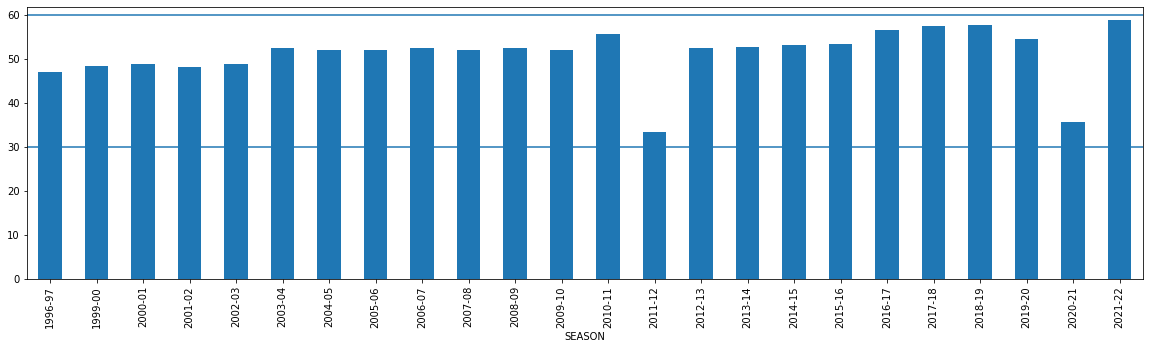

In [ ]:
# now fixed
df.groupby('SEASON').GP.mean().plot(kind='bar')
plt.axhline(30)
plt.axhline(60)

In [ ]:
# fix datatypes
df.loc[:, 'TEAM_ID'] = df['TEAM_ID'].astype(str)
df.loc[:, 'CFID'] = df['CFID'].astype(str)
df.loc[:, 'PLAYOFF_RANKING'] = df['PLAYOFF_RANKING'].astype('category')
df.loc[:, 'SEASON'] = df['SEASON'].astype('category')


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 0 to 771
Data columns (total 96 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   TEAM_ID             712 non-null    object  
 1   TEAM_NAME           712 non-null    object  
 2   GP                  712 non-null    int64   
 3   W                   712 non-null    int64   
 4   L                   712 non-null    int64   
 5   W_PCT               712 non-null    float64 
 6   MIN                 712 non-null    float64 
 7   FGM                 712 non-null    float64 
 8   FGA                 712 non-null    float64 
 9   FG_PCT              712 non-null    float64 
 10  FG3M                712 non-null    float64 
 11  FG3A                712 non-null    float64 
 12  FG3_PCT             712 non-null    float64 
 13  FTM                 712 non-null    float64 
 14  FTA                 712 non-null    float64 
 15  FT_PCT              712 non-null    floa

# Train test split with unique identifier = TEAM_ID + SEASON
- hashing unique identifier
- alternative: stratified sampling by season

## *use stratified sampling instead

In [ ]:
# unique id = team id + season
df.loc[:, 'UNIQUE_ID'] = df['TEAM_ID'].astype(str) + df['SEASON'].str.replace('-','')

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [ ]:
# instead of train-test_split by random shuffling, hash the unique identifier for train-test split
# slight modification to the technique from Hands On Machine Learning by Aurélien Géron
def split_data_with_id_hash(data, test_ratio, id_column):
  ids = data[id_column]
  threshold = np.quantile(ids.apply(lambda x: crc32(np.int64(x))), test_ratio) # instead of using test_ratio * 2**32 as the threshold, this is more accurate
  in_test_set = ids.apply(lambda x: crc32(np.int64(x)) < threshold) 
  return data.loc[~in_test_set], data.loc[in_test_set]

In [ ]:
train_set, test_set = split_data_with_id_hash(df, 0.2, "UNIQUE_ID")

In [ ]:
print(f"size of full dataset: {df.shape}")
print(f"train-test ratio: {train_set.shape[0] / df.shape[0]:0.2} / {test_set.shape[0] / df.shape[0]:0.2}")

size of full dataset: (712, 97)
train-test ratio: 0.8 / 0.2


In [ ]:
# save to google drive
os.chdir('/content/drive/MyDrive/Colab Notebooks')
train_set.to_pickle('nba_pre_all_star_vs_playoff_train_comprehensive.pkl')
test_set.to_pickle('nba_pre_all_star_vs_playoff_test_comprehensive.pkl')
# download local copy
from google.colab import files
files.download("nba_pre_all_star_vs_playoff_train_comprehensive.pkl")
files.download("nba_pre_all_star_vs_playoff_test_comprehensive.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>